In [1]:
"""
Test Script

"""
import random
import copy
import numpy as np
from vwgym import VacuumWorld, Vectorise, StepWrapper
from fun_lite import *
from torch.distributions import Categorical

random.seed(518123)

if torch.cuda.is_available():
    print('GPU Available:\t', True)
    device = 'cuda'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

else:
    device = 'cpu'

GPU Available:	 True


In [2]:
model_path = 'saved_model/fnet_ckpt.pt'

env, input_shape = make_env(grid_size=3, num_env=1, vectorize=True)
env = env[0]
env.state()

<class 'vacuumworld.vw.Grid'>: size: 3, agents: 1, dirts: 6, 
location(coordinate=coord(x=1, y=0), agent=agent(name='A-1', colour='white', orientation='east'), dirt=dirt(name='D-1', colour='orange'))
location(coordinate=coord(x=2, y=0), agent=None, dirt=dirt(name='D-3', colour='orange'))
location(coordinate=coord(x=0, y=1), agent=None, dirt=dirt(name='D-4', colour='green'))
location(coordinate=coord(x=1, y=1), agent=None, dirt=dirt(name='D-5', colour='green'))
location(coordinate=coord(x=0, y=2), agent=None, dirt=dirt(name='D-2', colour='orange'))
location(coordinate=coord(x=2, y=2), agent=None, dirt=dirt(name='D-6', colour='green'))


<class 'vacuumworld.vw.Grid'>: size: 3, agents: 1, dirts: 6, 
location(coordinate=coord(x=1, y=0), agent=agent(name='A-1', colour='white', orientation='east'), dirt=dirt(name='D-1', colour='orange'))
location(coordinate=coord(x=2, y=0), agent=None, dirt=dirt(name='D-3', colour='orange'))
location(coordinate=coord(x=0, y=1), agent=None, dirt=dirt(name='D-4', colour='green'))
location(coordinate=coord(x=1, y=1), agent=None, dirt=dirt(name='D-5', colour='green'))
location(coordinate=coord(x=0, y=2), agent=None, dirt=dirt(name='D-2', colour='orange'))
location(coordinate=coord(x=2, y=2), agent=None, dirt=dirt(name='D-6', colour='green'))

In [3]:
checkpoint = torch.load(model_path)

In [4]:
num_actions = env.action_space.n
f_net = FuNet(input_shape, 256,
              10,
              0.001,
              16,
              num_actions,
              1, device)

In [5]:
f_net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [6]:
f_net

FuNet(
  (f_percept): Percept(
    (percept): Linear(in_features=22, out_features=256, bias=True)
  )
  (manager): Manager(
    (M_space): Linear(in_features=256, out_features=256, bias=True)
    (M_goals): Linear(in_features=256, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (M_value): Linear(in_features=512, out_features=1, bias=True)
  )
  (worker): Worker(
    (f_stateW): Linear(in_features=256, out_features=64, bias=True)
    (phi): Linear(in_features=256, out_features=16, bias=False)
    (wfc1): Linear(in_features=64, out_features=1024, bias=True)
    (wfc2): Linear(in_features=1024, out_features=512, bias=True)
    (W_value): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [7]:
goal_history = checkpoint['goal']
s_Mt_hist = checkpoint['man_state']

In [8]:
def take_action(action_probs):
    action = action_probs.max(1)[1]
    return action.cpu().numpy()

In [9]:
import matplotlib.pyplot as plt

def plot_event(vw, action, action_p):
    
    action_meanings = ['move', 'clean', 'turn_left', 'turn_right', 'init']
    orientation = ['north', 'east', 'south', 'west']
    
    a_p = action_p.detach().cpu().numpy()
    o, l, d = vw[:4], vw[4:].reshape(2, 3, 3)[0], vw[4:].reshape(2, 3, 3)[1]
    
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(1, 12)

    f_ax2 = fig.add_subplot(gs[0, 0])
    plt.imshow(o.reshape(4, 1), cmap='binary')
    f_ax2.axes.xaxis.set_visible(False)
    f_ax2.axes.yaxis.set_visible(False)

    f_ax3 = fig.add_subplot(gs[0, 1:6])
    plt.imshow(l, cmap='magma')
    f_ax3.axes.xaxis.set_visible(False)
    f_ax3.axes.yaxis.set_visible(False)
    f_ax3.set_title(f'dir.: {orientation[o.reshape(1, 4).argmax()].upper()}; action selected: {action_meanings[action].upper()}')

    f_ax4 = fig.add_subplot(gs[0, 6:11])
    plt.imshow(d, cmap='Oranges')
    f_ax4.axes.xaxis.set_visible(False)
    f_ax4.axes.yaxis.set_visible(False)

    f_ax5 = fig.add_subplot(gs[0, -1])
    plt.imshow(a_p.reshape(4, 1), cmap='Greys')
    f_ax5.axes.xaxis.set_visible(False)
    f_ax5.axes.yaxis.set_visible(False)
    
    return fig

Dirts Present..:6

Grid Cleaned !!

{'ep_rewards': 589, 'ep_len': 18, 'move': 7, 'clean': 6, 'turn_left': 1, 'turn_right': 4}
Episode Rewards:	 589 
 ----------------------------------------


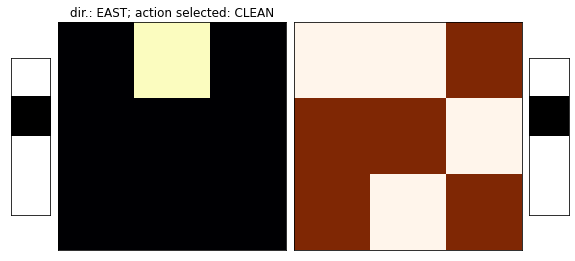

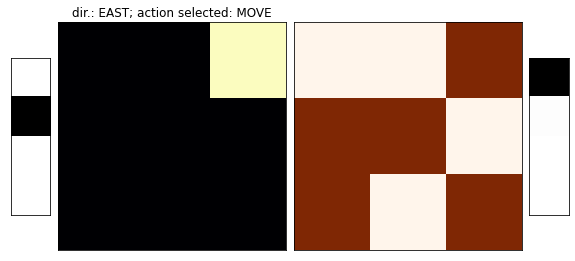

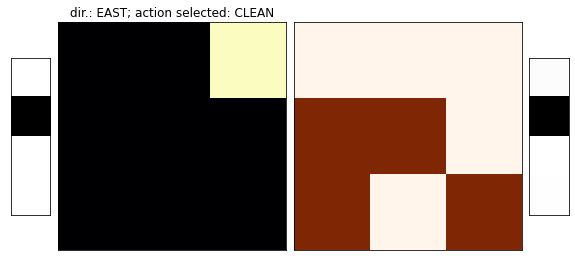

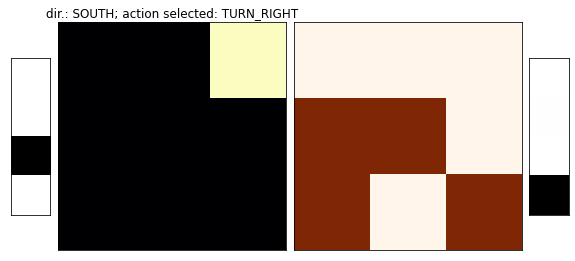

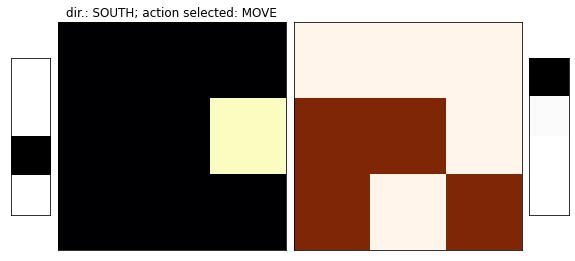

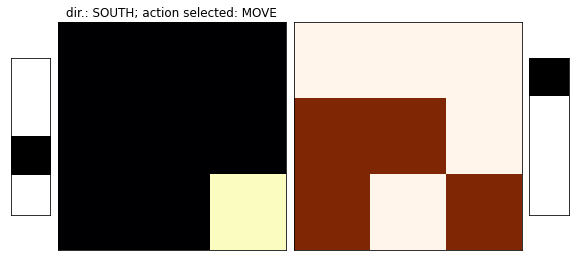

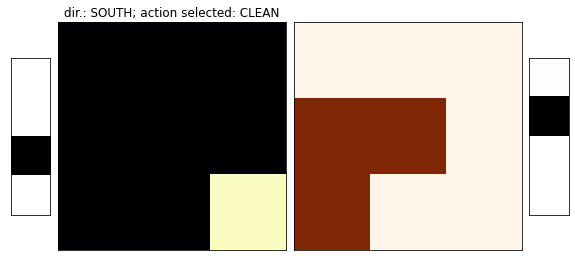

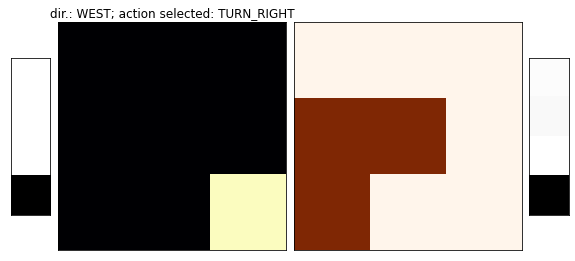

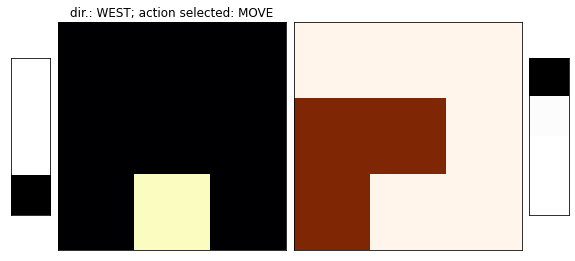

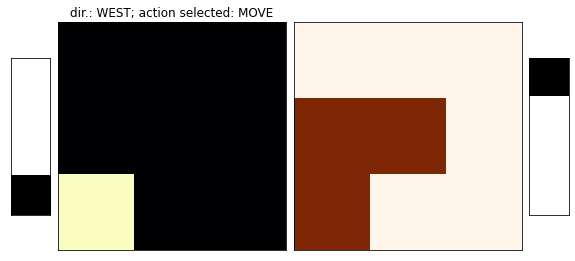

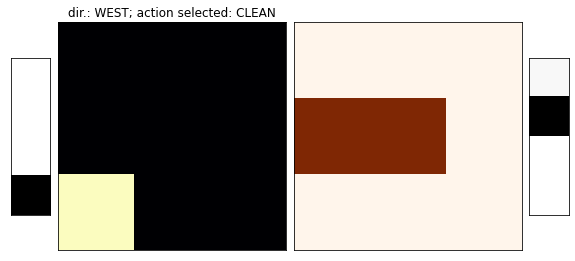

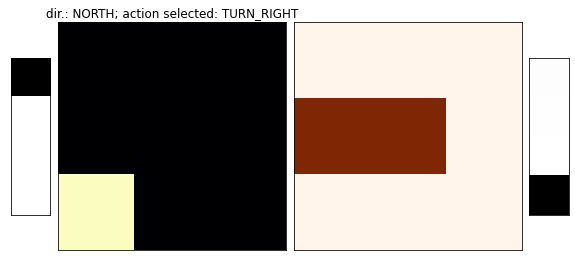

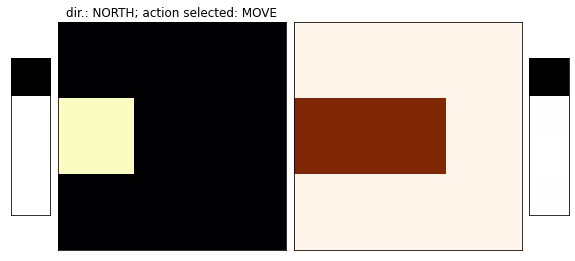

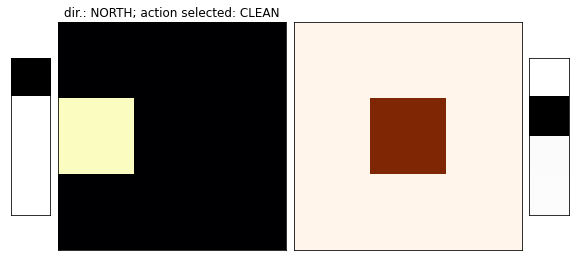

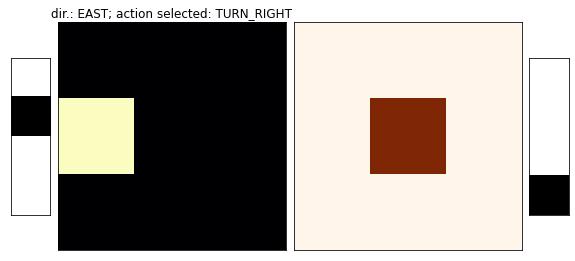

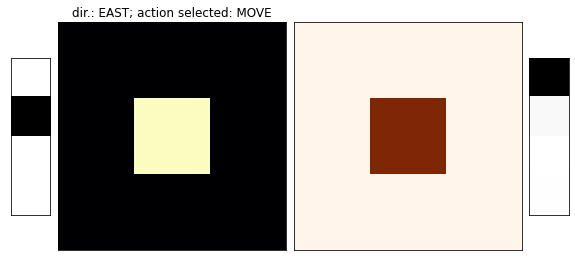

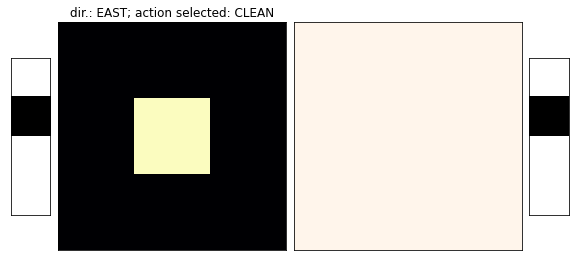

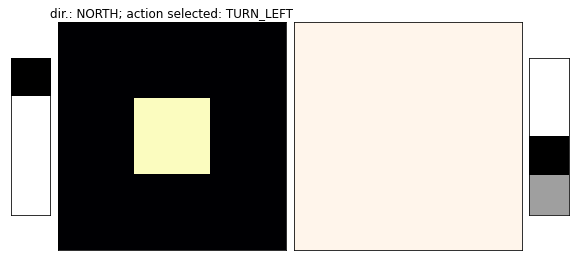

In [10]:
with torch.no_grad():

    f_net.eval()
    predictions = []
    
    x = env.reset()
    env.rw_dirts = env.dirts
    print(f'Dirts Present..:{env.rw_dirts}')
        
    x = torch.from_numpy(x).float()
    x = x.view(1, -1).to(device)
    
    step = 0
    prev_action = []
    
    for __ in range(5000):
        action_probs, v_Mt, v_Wt, goal_history, s_Mt_hist  = f_net(x, goal_history, s_Mt_hist)
        a_t = take_action(action_probs)
        x, reward, done, ep_info = env.step(a_t[0])
        plot_event(x, a_t[0], action_probs)
        
        x = torch.from_numpy(x).float()
        x = x.view(1, -1).to(device)

        predictions.append(a_t[0])
        if done:
            break

In [11]:
import pandas as pd

p = pd.DataFrame.from_dict({'actions': predictions, 'action_meanings':[env.action_meanings[i] for i in predictions]})
p['action_meanings'].value_counts().reset_index()

,index,action_meanings
0,move,7
1,clean,6
2,turn_right,4
3,turn_left,1


In [12]:
print('Action Sequence - FuN-Lite')
print('-'*20)
for i in [env.action_meanings[i] for i in predictions]:
    print('-', i)

Action Sequence - FuN-Lite
--------------------
- clean
- move
- clean
- turn_right
- move
- move
- clean
- turn_right
- move
- move
- clean
- turn_right
- move
- clean
- turn_right
- move
- clean
- turn_left
